# ARIMA Lab

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import warnings # necessary b/c pandas & statsmodels datetime issue
warnings.simplefilter(action="ignore")

## Importing the data

### Data checks: 
After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [2]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


In [3]:
#does not seem like any missing value, Date datatype needs to be changed
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


### Creating a datetime index:

Convert the `Date` column to datetime, and set it as the index for the dataframe.

In [4]:
#change `date` into datetime type
walmart.Date=pd.to_datetime(walmart.Date)

In [5]:
#set `date` as index and sort index
walmart=walmart.set_index(walmart.Date).sort_index()

In [6]:
#chceck walmart
walmart.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
Date,,,,,
2010-02-05,1,1,2010-02-05,24924.50,False
2010-02-05,29,5,2010-02-05,15552.08,False
2010-02-05,29,6,2010-02-05,3200.22,False
2010-02-05,29,7,2010-02-05,10820.05,False
2010-02-05,29,8,2010-02-05,20055.64,False


### Getting weekly sales for store 1:

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **groupby**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [15]:
#filter to store 1
df=walmart[walmart['Store']==1]

In [19]:
#group by datetime and aggregate the sales to each date entry
df=df.groupby(df.index)[['Weekly_Sales']].sum()

In [20]:
df.head()

,Weekly_Sales
Date,
2010-02-05,1643690.90
2010-02-12,1641957.44
2010-02-19,1611968.17
2010-02-26,1409727.59
2010-03-05,1554806.68


---

## Plotting and interpreting a time series

### Generate a line plot:

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

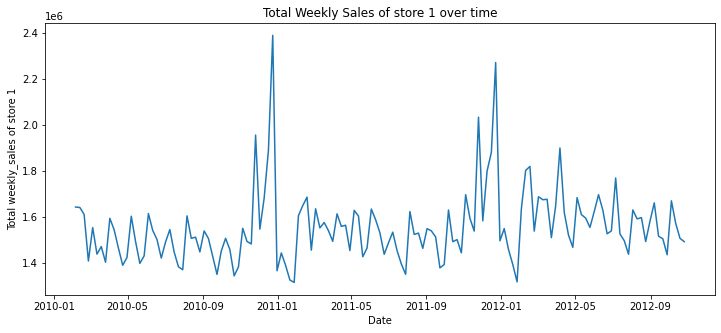

In [25]:
plt.figure(figsize=(12,5))
plt.plot(df)
plt.title('Total Weekly Sales of store 1 over time')
plt.xlabel('Date')
plt.ylabel('Total weekly_sales of store 1');

### Plotting rolling means:

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

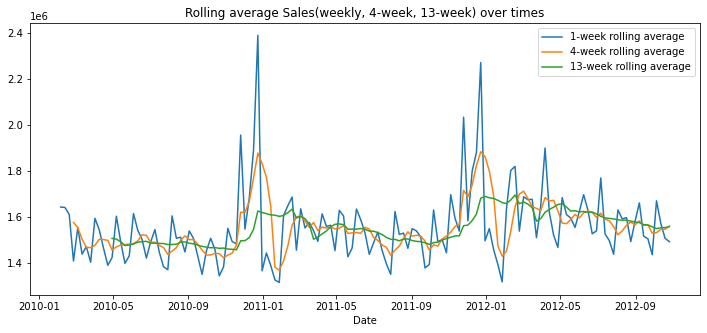

In [32]:
plt.figure(figsize=(12,5))
for i in [1,4,13]:
    plt.plot(df.rolling(i).mean(), label=f'{i}-week rolling average')
plt.title('Rolling average Sales(weekly, 4-week, 13-week) over times')
plt.xlabel('Date')
plt.legend();

### (Short answer) Describe any trends that you notice:

**Answer:** 
* The week sales data looks stationary with a constant mean and variance.
* There is a clear seasonable pattern.At Xmas time there is a sudden increase in sales. 

---

## Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

### Plot and interpret the autocorrelation:

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. What do you notice? (Your answer can be given in bullet points; full sentences are not required.)

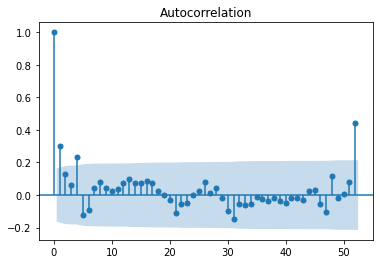

In [74]:
plot_acf(df, lags=52);

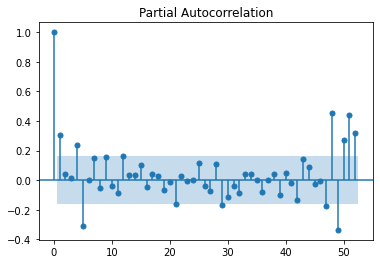

In [73]:
plot_pacf(df, lags=52);

**Answer:**
* From ACF and PCAF, there is not so much strong patterns in short range, a decent correlation appears at around 2, 5, 6, and very strong correlation at 48, 49, 50.

---

## Modeling

### Train-test splitting:

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [40]:
train, test=train_test_split(df['Weekly_Sales'], shuffle=False, test_size=.2)

In [41]:
train.shape

(114,)

In [42]:
test.shape

(29,)

### Evaluating stationarity:

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [38]:
adfuller(df)

(-5.102186145192292,
 1.3877788330759122e-05,
 4,
 138,
 {'1%': -3.47864788917503,
  '5%': -2.882721765644168,
  '10%': -2.578065326612056},
 3412.7325502876756)

#### Adfuller interetation is to see if ther p-value is high enough to reject the alternative hypothesis; if p-value is low, we reject the null hypothesis(data is non-stationary)
* In this case, since the p-value is 1.38e-5 almost 0, we can safely say the sales data is stationary



---

### Fit and evaluate an AR(1) model:

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data:

In [68]:
def get_arima_fit(p=1, l=0, q=0):
    #fit arima model
    arima=ARIMA(train, order=(p,l,q)).fit()
    

    #predictions on train and test
    train_preds=arima.predict()
    test_preds=arima.predict(start=test.index[0], end=test.index[-1])
    #mean squared error
    print(f'The mean squared error of arima model {(p, l, q)} is: {mean_squared_error(test, test_preds)}')    
    print('--'*40)
    
    #plot predictions on train and test
    plt.figure(figsize=(12,5))
    plt.plot(train, color='blue', label='train')
    plt.plot(train_preds, color='green', label='predicted train', linestyle='-.')
    plt.plot(test, color='red', label='test')
    plt.plot(test_preds, color='orange', label='predicted test', linestyle='-.')
    plt.title('Predicted sales on train and test dataset using AR1 model')
    plt.xlabel('Date')
    plt.legend();
    
    return arima

    

The mean squared error of arima model (1, 0, 0) is: 6807103438.05624
--------------------------------------------------------------------------------


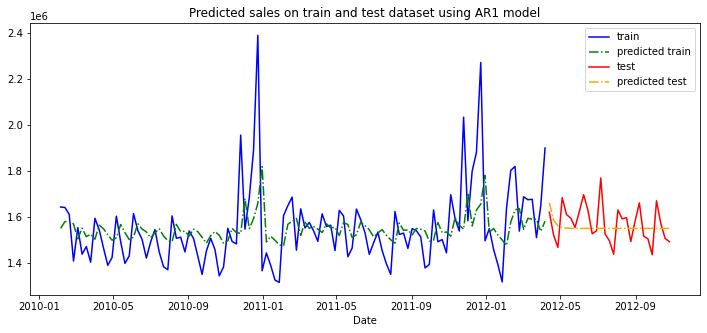

In [69]:
ar1=get_arima_fit(1,0,0)

In [61]:
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  114
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1528.191
Date:                Sun, 31 Oct 2021   AIC                           3062.381
Time:                        23:49:03   BIC                           3070.590
Sample:                    02-05-2010   HQIC                          3065.712
                         - 04-06-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.551e+06   2.63e+04     58.955      0.000     1.5e+06     1.6e+06
ar.L1          0.3198      0.055      5.861      0.000       0.213       0.427
sigma2       2.59e+10      0.197   1.32e+11      0.000    2.59e+10    2.59e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               164.73
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               4.17   Skew:                             1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.08e+25. Standard errors may be unstable.
"""

### Evaluating the model:

#### Store predictions:

Remember that statsmodels ARIMA models generate predictions off of `start` and `end` dates.

Generate and store predictions for the training and testing data:

In [63]:
#see above

#### Mean squared error:

Use the `mean_squared_error` function to identify the MSE on the testing data:

In [62]:
#see above

#### Generate a plot of the training data, testing data, train preds, and test preds:

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

In [64]:
#see above

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.


**Answer:** 
* the prediction on train is pretty good on catching the trend, the test prediction is not very good. Model is pretty much predictting the mean. Model overfit.

---

### Fit and evaluate an ARMA(2,2) model:

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

The mean squared error of arima model (2, 0, 2) is: 6332181014.642554
--------------------------------------------------------------------------------


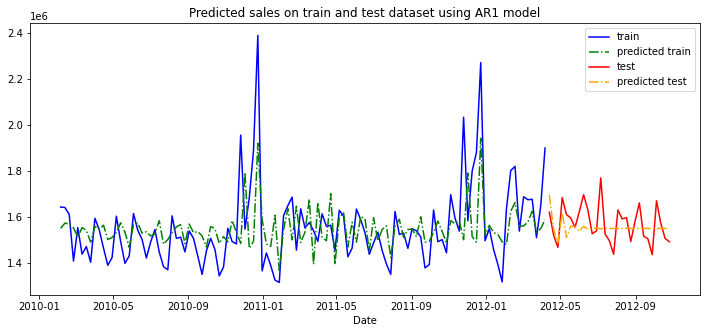

In [70]:
ar2=get_arima_fit(2,0,2)

### Evaluating the model:

#### Store predictions:

Generate and store predictions for train and test:

In [ ]:
#see above

#### Mean squared error:

Find the MSE of the testing data:

In [ ]:
#see above

#### Generate a plot of the training data, testing data, train preds, and test preds:

As before, plot your data and predictions.

In [ ]:
#see above

#### Intepretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

* it's improved but still not predictin anything better than the mean for test

---

### Fit and evaluate an ARIMA(2,1,2) model:

Instantiate and fit an ARIMA model with order $(2,1,2)$:

The mean squared error of arima model (2, 1, 2) is: 16238247694.442383
--------------------------------------------------------------------------------


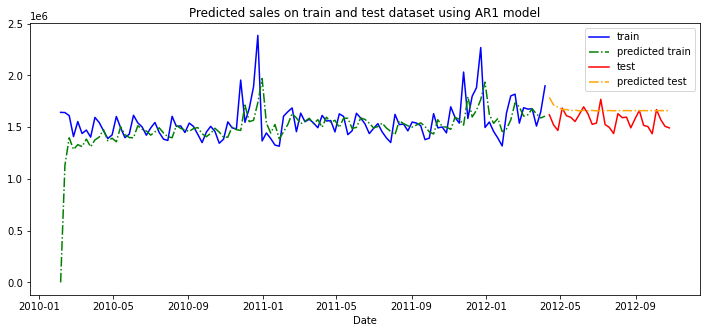

In [71]:
ar3=get_arima_fit(2,1,2)

### Evaluating the model:

#### Store predictions:

Generate and store predictions for train and test:

In [ ]:
#above

#### Mean squared error:

Find the MSE on your testing data:

In [ ]:
#see above

#### Generate a plot of the training data, testing data, train preds and test preds:

As before, plot your data and predictions.

In [ ]:
#see above

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

* I don't think add the integration function helped the model getting better

---

### Fit and evaluate an ARIMA(52,0,1) model:

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$:

The mean squared error of arima model (52, 0, 1) is: 9235642275.811987
--------------------------------------------------------------------------------


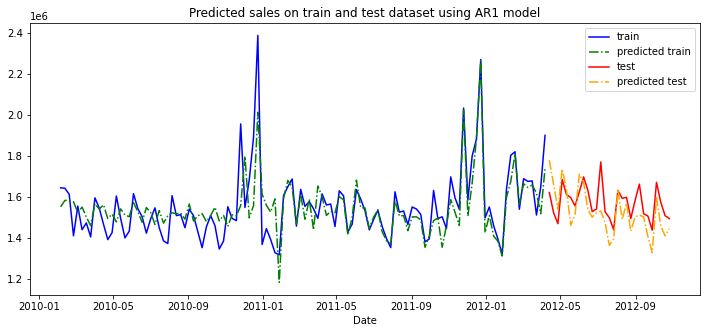

In [72]:
ar52=get_arima_fit(52,0,1)

### Evaluating the model:

#### Store predictions:

Generate and store predictions for train and test:

In [ ]:
# see above

#### Mean squared error:

Find the MSE on your testing data:

In [ ]:
#see above

#### Generate a plot of the training data, testing data, train preds and test preds:

As before, plot your data and predictions.

In [ ]:
#see above

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

* Based on the ACF and PACF, how it make sense the model is much more improved after we included strongly correlated lags (~50).

---

## (BONUS) SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows exogenous data to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.